In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

import numpy as np # linear algebra
import pandas as pd 
from utils import *

import os
import numpy as np
from tempfile import TemporaryFile
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, GaussianNoise
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l1

In [2]:
tf.enable_eager_execution()

This is the training pipeline:

-a classifier is trained for every chanel

-to use this pipepline change to value of the variable "idc" bellow and run each cell 

In [40]:
idc = 0

In [41]:
### Loads in the channel
xtest_chan7 = np.load("channels/channel_{}_xtest.npy".format(idc))
xtrain_chan7 = np.load("channels/channel_{}_xtrain.npy".format(idc))

### NB: Labels for each channel are the same
ytest_chan7 = np.load("channels/channel_5_ytest.npy")
ytrain_chan7 = np.load("channels/channel_5_ytrain.npy")

In [42]:
### obtain predictions for one-hot encoding
ytrain = np.argmax(ytrain_chan7, axis = 1)
ytest = np.argmax(ytest_chan7, axis = 1)

In [43]:
### Crop and resize the images 
###  140*140 center crop was done and the image was then resiszed to 50*50 
im_size = 50
xtrain = np.array(crop_resize(xtrain_chan7, 140, im_size)).reshape((xtrain_chan7.shape[0], im_size,im_size, 1))
xtest = np.array(crop_resize(xtest_chan7, 140, im_size)).reshape((xtest_chan7.shape[0], im_size,im_size, 1))

2


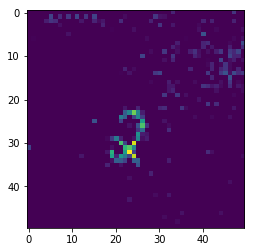

6


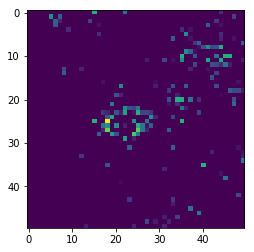

7


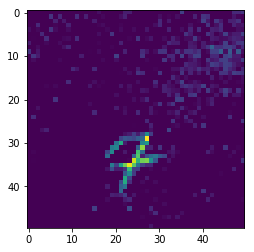

0


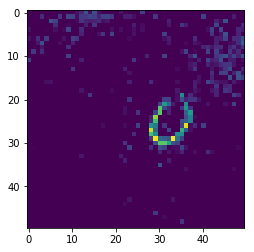

9


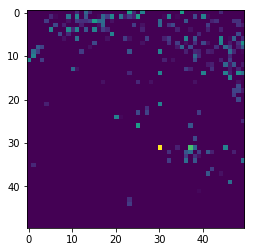

In [44]:
### Display the image and labels for 5 images in the dataset
i = 10 ###start index
for x in range(5):
    print(ytrain[x+i])
    plt.imshow(xtrain[x+i].reshape(im_size,im_size))
    plt.show()

8


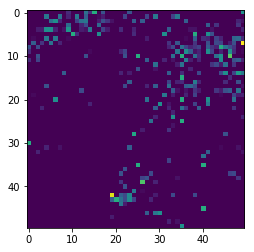

1


0


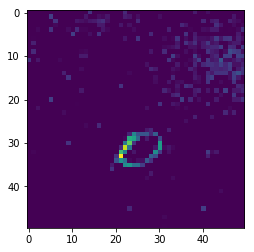

0


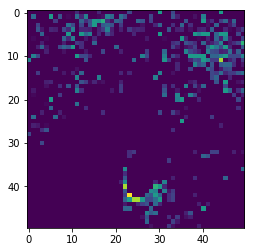

4


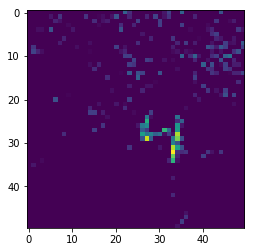

In [45]:
### Displays 5 images and their respective labels from the test set 
i = 68 
for x in range(5):
    print(ytest[x+i])
    plt.imshow(xtest[x+i].reshape(im_size,im_size))
    plt.show()

In [46]:
print(xtrain.shape)
print(ytrain.shape)

(477, 50, 50, 1)
(477,)


In [61]:

im_size =50
batch_size = 120
num_classes = 10
lr = 0.001 ### learning rate
input_shape = ( im_size, im_size, 1)
l1_lambda = 0.0003 ### L1 regularization lambda parameter

In [71]:
### Creating model architecture


he_init = tf.keras.initializers.VarianceScaling()
model = Sequential()
model.add(BatchNormalization(input_shape=input_shape))
model.add(Conv2D(64, (2, 2), kernel_regularizer=l1(l1_lambda), activation='elu', 
                 kernel_initializer =he_init))

model.add(GaussianNoise(0.01))
model.add(Conv2D(64, (2, 2), kernel_regularizer=l1(l1_lambda), activation='elu', 
                 kernel_initializer =he_init))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(Conv2D(128, (2, 2), kernel_regularizer=l1(l1_lambda), activation='elu', 
                 kernel_initializer =he_init))

model.add(GaussianNoise(0.01))
model.add(Conv2D(128, (2, 2), kernel_regularizer=l1(l1_lambda), activation='elu', 
                 kernel_initializer =he_init))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(Conv2D(256, (2, 2), kernel_regularizer=l1(l1_lambda), activation='elu', 
                 kernel_initializer =he_init))

model.add(GaussianNoise(0.1))
model.add(Conv2D(256, (2, 2), kernel_regularizer=l1(l1_lambda), activation='elu', 
                 kernel_initializer =he_init))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(1024, activation='elu', kernel_regularizer=l1(l1_lambda), kernel_initializer =he_init))
model.add(Dropout(0.2))

model.add(Dense(1024, activation='elu',kernel_initializer =he_init))
model.add(Dropout(0.2))
model.add(GaussianNoise(0.01))
model.add(Dense(num_classes, activation='softmax', kernel_initializer =he_init))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_v1_5 (Ba (None, 50, 50, 1)         4         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 49, 49, 64)        320       
_________________________________________________________________
gaussian_noise_15 (GaussianN (None, 49, 49, 64)        0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 48, 48, 64)        16448     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 24, 24, 64)        0         
_________________________________________________________________
dropout_25 (Dropout)         (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 23, 23, 128)       32896     
__________

In [72]:
### This loads in saved weights only run if the notebook some how restart and you want to
### reinitialized trained weights
#model.load_weights("Models/model{}.h5".format(idc))

In [73]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(#rotation_range = 5,
                             width_shift_range = [1, 5],
                             height_shift_range = [1, 5],
                             #brightness_range = (.1, 5),
                             shear_range = 5.0
                            )
datagen.fit(xtrain)

In [74]:
path = "tf_keras_models/"

In [75]:
opt = tf.keras.optimizers.Adam(lr)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

#tensorboard = TensorBoard(log_dir='./logs', write_graph=True)
#checkpoint = ModelCheckpoint(filepath=os.path.join(path, "model-{epoch:02d}.h5"))
"""
model.fit_generator(datagen.flow(train_data, train_labels,
          batch_size=batch_size),
          epochs=epochs,
          verbose=1,
          validation_data=(test_data, test_labels),
          callbacks=[tensorboard])
"""

'\nmodel.fit_generator(datagen.flow(train_data, train_labels,\n          batch_size=batch_size),\n          epochs=epochs,\n          verbose=1,\n          validation_data=(test_data, test_labels),\n          callbacks=[tensorboard])\n'

In [76]:
epochs = 100
batch_size = 477
model.fit_generator(datagen.flow(xtrain, ytrain_chan7, batch_size = batch_size),
          epochs=epochs,
          verbose=1,
          validation_data=(xtest, ytest_chan7),
          #callbacks=[ checkpointer]
         )
# Any results you write to the current directory are saved as

Epoch 1/100
1/1 [==============================] - 12s 12s/step - loss: 23.6170 - acc: 0.8302 - val_loss: 27.4217 - val_acc: 0.3008
Epoch 2/100
1/1 [==============================] - 4s 4s/step - loss: 25.7552 - acc: 0.3438 - val_loss: 26.0198 - val_acc: 0.2458
Epoch 3/100
1/1 [==============================] - 4s 4s/step - loss: 25.5207 - acc: 0.2956 - val_loss: 25.0508 - val_acc: 0.3347
Epoch 4/100
1/1 [==============================] - 4s 4s/step - loss: 24.4032 - acc: 0.3836 - val_loss: 24.1238 - val_acc: 0.3686
Epoch 5/100
1/1 [==============================] - 4s 4s/step - loss: 23.8070 - acc: 0.3899 - val_loss: 23.1236 - val_acc: 0.3686
Epoch 6/100
1/1 [==============================] - 4s 4s/step - loss: 22.5961 - acc: 0.4486 - val_loss: 22.0129 - val_acc: 0.4661
Epoch 7/100
1/1 [==============================] - 4s 4s/step - loss: 21.4432 - acc: 0.5325 - val_loss: 21.3849 - val_acc: 0.4958
Epoch 8/100
1/1 [==============================] - 4s 4s/step - loss: 20.7289 - acc: 0.5

In [33]:
score = model.evaluate(xtest, ytest_chan7, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
pred = model.predict(xtest)

Test loss: 0.26396609564958995
Test accuracy: 0.970339


In [166]:
ytest_chan7.T.shape

(10, 236)

In [167]:
pred.T.shape

(10, 236)

In [168]:
print("-Confusion matrix")
confuse = tf.math.confusion_matrix(np.argmax(ytest_chan7,axis = 1), np.argmax(pred, axis = 1), num_classes = 10)
print(confuse)

tf.Tensor(
[[10  1  3  3  0  2  4  1  2  0]
 [ 0 18  1  1  1  2  0  0  1  1]
 [ 1  0 15  1  1  4  1  0  1  0]
 [ 0  0  1 14  1  6  0  1  0  0]
 [ 0  1  3  0 13  2  0  4  1  1]
 [ 0  0  3  2  0 12  4  0  1  0]
 [ 0  0  0  0  1  5 15  0  3  0]
 [ 0  2  0  3  1  3  3 15  0  1]
 [ 0  0  2  1  0  3  1  0 13  0]
 [ 0  3  0  0  2  1  0  3  1  9]], shape=(10, 10), dtype=int32)


In [169]:
np.argmax(pred,axis = 1)

array([9, 5, 7, 2, 6, 2, 5, 1, 4, 5, 2, 4, 2, 5, 0, 6, 4, 5, 1, 6, 5, 3,
       5, 9, 5, 8, 4, 7, 5, 2, 6, 5, 6, 7, 7, 8, 0, 5, 7, 5, 7, 5, 5, 5,
       6, 3, 9, 9, 6, 1, 1, 8, 8, 4, 2, 3, 8, 5, 1, 5, 1, 2, 7, 5, 1, 3,
       6, 4, 2, 8, 0, 0, 9, 7, 7, 9, 5, 8, 6, 3, 3, 7, 6, 8, 0, 2, 8, 7,
       6, 7, 2, 1, 1, 6, 9, 2, 2, 7, 5, 4, 8, 3, 6, 2, 0, 5, 0, 2, 7, 4,
       8, 6, 2, 4, 2, 2, 3, 6, 8, 1, 3, 1, 8, 4, 2, 5, 7, 7, 3, 8, 3, 1,
       5, 1, 3, 6, 1, 3, 9, 7, 6, 0, 5, 3, 8, 6, 5, 9, 8, 7, 0, 1, 6, 2,
       3, 5, 9, 3, 6, 1, 7, 1, 5, 5, 3, 3, 6, 5, 5, 5, 5, 1, 1, 3, 5, 4,
       2, 8, 4, 6, 2, 4, 4, 0, 8, 8, 2, 6, 6, 2, 5, 7, 1, 4, 7, 4, 9, 1,
       2, 1, 1, 4, 6, 5, 3, 9, 5, 3, 5, 0, 3, 1, 4, 5, 6, 2, 6, 8, 8, 4,
       7, 8, 7, 2, 2, 2, 7, 3, 1, 4, 3, 6, 5, 3, 8, 5])

In [170]:
np.argmax(ytest_chan7, axis = 1)

array([9, 5, 4, 2, 6, 2, 8, 9, 2, 5, 2, 4, 5, 9, 0, 6, 9, 0, 1, 6, 8, 3,
       6, 7, 1, 8, 4, 7, 3, 2, 0, 5, 6, 3, 7, 2, 0, 3, 7, 5, 7, 5, 7, 5,
       8, 0, 1, 9, 6, 0, 9, 8, 8, 4, 2, 3, 8, 5, 1, 6, 1, 3, 7, 3, 1, 3,
       7, 4, 8, 1, 0, 0, 4, 4, 0, 9, 5, 8, 6, 3, 8, 7, 6, 0, 0, 8, 8, 7,
       6, 7, 4, 9, 1, 0, 9, 2, 2, 7, 3, 4, 9, 3, 6, 0, 0, 8, 2, 2, 9, 4,
       8, 7, 5, 4, 2, 1, 7, 6, 8, 1, 3, 1, 0, 6, 5, 2, 9, 7, 3, 8, 3, 1,
       6, 7, 3, 7, 1, 5, 9, 7, 5, 0, 0, 1, 8, 0, 2, 9, 4, 7, 0, 1, 0, 4,
       7, 4, 9, 3, 6, 1, 4, 1, 6, 5, 3, 0, 6, 3, 7, 6, 5, 1, 1, 3, 1, 7,
       4, 8, 4, 6, 2, 4, 9, 0, 8, 6, 0, 6, 5, 2, 2, 9, 7, 4, 7, 4, 9, 1,
       0, 1, 1, 3, 5, 3, 3, 9, 5, 7, 4, 0, 5, 1, 1, 5, 2, 2, 6, 5, 8, 4,
       4, 6, 7, 2, 2, 2, 7, 2, 4, 4, 0, 5, 7, 3, 6, 2])

Interesting the model is seeing everything in the validation set as one particular class
overfiting----- high variance
options





1 more data ?
2 regularization
3 more appropriate architecture

In [36]:
### Saving model
model_json = model.to_json()
with open("Models/model{}_json.json".format(idc), "w") as j_file:
    j_file.write(model_json)

In [37]:
### Saving model's weights
model.save_weights("Models/model{}.h5".format(idc))